# Posture Detection Model

## 1 Engineer features

### 1.1 Import libraries and define transformers  

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, make_union
from keras.utils import to_categorical
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import warnings
warnings.filterwarnings("ignore")
import ipytest.magics
import pytest
__file__ = 'drone_pos_model_christian.ipynb'

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
class Shuffler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        x=x.loc[np.random.permutation(x.index)]
        
        return x

In [4]:
class XCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, x_columns):
        self.x_columns = x_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_x","leftShoulder_x"]].sum(axis=1)/4
        for col in self.x_columns:
            x[col] = x[col] - shift
        return x

In [5]:
class YCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, y_columns):
        self.y_columns = y_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_y","leftShoulder_y","leftHip_y","rightHip_y"]].sum(axis=1)/4
        for col in list(set(self.y_columns)-set(["label"])):
            x[col] = x[col] - shift
        return x

In [6]:
class YScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shoulder_y = x[["rightShoulder_y","leftShoulder_y"]].sum(axis=1)/2
        hip_y = x[["leftHip_y","rightHip_y"]].sum(axis=1)/2
        y_dist = hip_y - shoulder_y
        
        for col in list(set(x.columns)-set(["label"])):
            x[col] /= y_dist
        return x

### 1.2  Inspect data

In [7]:
path = "posture_training_data"
df = pd.read_csv("../data/posture/"+ path + ".csv",low_memory=False)
df = df.dropna().drop_duplicates()
print(df.shape)
df.head()

(1867, 13)


,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
0,364.388477,175.727292,326.376146,176.318343,373.932203,185.283770,323.401138,178.613052,363.882516,247.058341,335.419796,245.791503,3
9,362.043733,162.669425,322.806684,162.934143,368.892477,106.262375,314.567677,103.431298,360.476755,244.545429,332.341002,246.078227,1
10,361.398062,161.761029,319.718081,157.452745,359.997208,94.588426,315.145723,95.310308,358.496267,245.388146,332.033283,245.604833,1
11,356.940976,156.356530,317.715580,160.940937,355.271911,92.585746,315.198539,95.782529,355.675736,241.225170,332.092374,243.839404,1
12,355.355181,159.860870,319.357292,159.059428,355.228806,95.781997,315.496033,96.264859,355.045702,243.383177,330.646016,244.469512,1


In [8]:
assert df.isnull().all().all() == False

### 1.3 Set pipeline arguments

In [9]:
x_cols = ['leftShoulder_x', 'rightShoulder_x', 'leftWrist_x', 'rightWrist_x', 'leftHip_x' ,'rightHip_x']
y_cols = list(set(df.columns)-set(x_cols))

### 1.4 Build data processing pipeline

In [10]:
processing_pipeline = make_pipeline(XCentralizer(x_cols), YCentralizer(y_cols), YScaler(), Shuffler())
processed_df = processing_pipeline.fit_transform(df)
processed_df.head()

,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
555,2.722892,-0.504198,2.182960,-0.495802,2.858452,-0.368456,2.140703,-0.463208,2.715705,0.508997,2.311417,0.491003,3
1505,2.312823,-0.501604,1.837280,-0.498396,2.395828,-1.185243,1.737426,-1.219555,2.293832,0.490711,1.952834,0.509289,1
560,2.225171,-0.474920,1.739897,-0.525080,2.208861,-1.257000,1.686662,-1.248596,2.191386,0.498739,1.883281,0.501261,1
300,2.244502,-0.527326,1.776885,-0.472674,2.224605,-1.287556,1.746879,-1.249446,2.229419,0.484417,1.948275,0.515583,1
1715,2.210080,-0.495256,1.783899,-0.504744,2.208584,-1.253889,1.738185,-1.248173,2.206416,0.493569,1.917547,0.506431,1


In [11]:
assert df.shape[0] == processed_df.shape[0]

## 2 Train model

### 2.1  Split in train / test

In [12]:
df_train = processed_df.iloc[:int(processed_df.shape[0]*0.8)]
df_test = processed_df.iloc[int(processed_df.shape[0]*0.8):]

In [13]:
assert df_train.shape[0] + df_test.shape[0] == df.shape[0]

### 2.2 Define numpy arrays as needed by model

In [14]:
x_train = df_train.drop(['label'], axis=1).values
y_train = df_train['label'].values

x_test = df_test.drop(['label'], axis=1).values
y_test = df_test['label'].values

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
print(x_train.shape, y_train.shape )
print("x_train[0]=", x_train[0],"\n y_train[0]=", y_train[0])

(1493, 12) (1493, 7)
x_train[0]= [ 2.72289192 -0.50419768  2.18296018 -0.49580232  2.85845216 -0.36845632
  2.14070281 -0.463208    2.7157052   0.50899717  2.31141728  0.49100283] 
 y_train[0]= [0. 0. 0. 1. 0. 0. 0.]


### 2.3 Define and compile model

In [16]:
from keras import models, layers
from keras.models import Model
from keras.layers import Input, Dense
from keras import optimizers, losses, metrics

model = models.Sequential()
model.add(layers.Dense(20, activation="relu", input_shape=(12, )))
model.add(layers.Dense(15, activation="relu"))
model.add(layers.Dense(7, activation="softmax")) 
model.summary()   

model.compile(optimizer=optimizers.RMSprop(lr=0.005),
              loss=losses.categorical_crossentropy,
              metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                260       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 112       
Total params: 687
Trainable params: 687
Non-trainable params: 0
_________________________________________________________________


### 2.4 Fit and validate model

In [17]:
history = model.fit(x_train, y_train, epochs=500, batch_size=30, validation_split=0.2)

Train on 1194 samples, validate on 299 samples
Epoch 1/500
1194/1194 [==============================] - 0s 282us/step - loss: 1.2715 - acc: 0.5670 - val_loss: 0.9053 - val_acc: 0.6890
Epoch 2/500
1194/1194 [==============================] - 0s 49us/step - loss: 0.6187 - acc: 0.8543 - val_loss: 0.5223 - val_acc: 0.7893
Epoch 3/500
1194/1194 [==============================] - 0s 49us/step - loss: 0.2912 - acc: 0.9456 - val_loss: 0.2109 - val_acc: 0.9599
Epoch 4/500
1194/1194 [==============================] - 0s 55us/step - loss: 0.1246 - acc: 0.9883 - val_loss: 0.0791 - val_acc: 0.9967
Epoch 5/500
1194/1194 [==============================] - 0s 54us/step - loss: 0.0593 - acc: 0.9941 - val_loss: 0.0389 - val_acc: 1.0000
Epoch 6/500
1194/1194 [==============================] - 0s 54us/step - loss: 0.0298 - acc: 0.9975 - val_loss: 0.0209 - val_acc: 1.0000
Epoch 7/500
1194/1194 [==============================] - 0s 56us/step - loss: 0.0172 - acc: 0.9983 - val_loss: 0.0119 - val_acc: 1.0000


Epoch 119/500
1194/1194 [==============================] - 0s 49us/step - loss: 6.2410e-04 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 0.9967
Epoch 120/500
1194/1194 [==============================] - 0s 61us/step - loss: 0.0022 - acc: 0.9992 - val_loss: 0.0100 - val_acc: 0.9967
Epoch 121/500
1194/1194 [==============================] - 0s 52us/step - loss: 1.4027e-04 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 0.9967
Epoch 122/500
1194/1194 [==============================] - 0s 52us/step - loss: 1.0431e-04 - acc: 1.0000 - val_loss: 0.0165 - val_acc: 0.9967
Epoch 123/500
1194/1194 [==============================] - 0s 55us/step - loss: 0.0066 - acc: 0.9983 - val_loss: 0.0139 - val_acc: 0.9967
Epoch 124/500
1194/1194 [==============================] - 0s 51us/step - loss: 4.6922e-04 - acc: 1.0000 - val_loss: 0.0224 - val_acc: 0.9967
Epoch 125/500
1194/1194 [==============================] - 0s 53us/step - loss: 0.0020 - acc: 0.9992 - val_loss: 0.0200 - val_acc: 0.9967
Epoch 126/500
1194

Epoch 235/500
1194/1194 [==============================] - 0s 52us/step - loss: 9.1904e-04 - acc: 0.9992 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 236/500
1194/1194 [==============================] - 0s 40us/step - loss: 5.1487e-07 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 237/500
1194/1194 [==============================] - 0s 49us/step - loss: 5.2156e-07 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 238/500
1194/1194 [==============================] - 0s 51us/step - loss: 2.0757e-05 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9933
Epoch 239/500
1194/1194 [==============================] - 0s 44us/step - loss: 0.0024 - acc: 0.9992 - val_loss: 0.0039 - val_acc: 0.9967
Epoch 240/500
1194/1194 [==============================] - 0s 48us/step - loss: 9.9612e-07 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 0.9967
Epoch 241/500
1194/1194 [==============================] - 0s 42us/step - loss: 7.6200e-07 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 242/

1194/1194 [==============================] - 0s 50us/step - loss: 4.2551e-07 - acc: 1.0000 - val_loss: 3.9874e-05 - val_acc: 1.0000
Epoch 350/500
1194/1194 [==============================] - 0s 51us/step - loss: 2.7282e-07 - acc: 1.0000 - val_loss: 9.7674e-05 - val_acc: 1.0000
Epoch 351/500
1194/1194 [==============================] - 0s 50us/step - loss: 1.7722e-07 - acc: 1.0000 - val_loss: 6.9660e-05 - val_acc: 1.0000
Epoch 352/500
1194/1194 [==============================] - 0s 49us/step - loss: 9.4653e-05 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9866
Epoch 353/500
1194/1194 [==============================] - 0s 60us/step - loss: 2.2101e-06 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 0.9866
Epoch 354/500
1194/1194 [==============================] - 0s 54us/step - loss: 4.5409e-07 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 0.9967
Epoch 355/500
1194/1194 [==============================] - 0s 59us/step - loss: 1.6753e-07 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 35

1194/1194 [==============================] - 0s 54us/step - loss: 3.4500e-05 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 0.9967
Epoch 464/500
1194/1194 [==============================] - 0s 54us/step - loss: 3.7334e-07 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 0.9967
Epoch 465/500
1194/1194 [==============================] - 0s 54us/step - loss: 1.8241e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 466/500
1194/1194 [==============================] - 0s 54us/step - loss: 1.2051e-07 - acc: 1.0000 - val_loss: 6.1312e-04 - val_acc: 1.0000
Epoch 467/500
1194/1194 [==============================] - 0s 49us/step - loss: 1.2036e-07 - acc: 1.0000 - val_loss: 1.6050e-05 - val_acc: 1.0000
Epoch 468/500
1194/1194 [==============================] - 0s 54us/step - loss: 1.8915e-07 - acc: 1.0000 - val_loss: 0.0663 - val_acc: 0.9866
Epoch 469/500
1194/1194 [==============================] - 0s 60us/step - loss: 0.0041 - acc: 0.9992 - val_loss: 4.0889e-06 - val_acc: 1.0000
Epoch 470/50

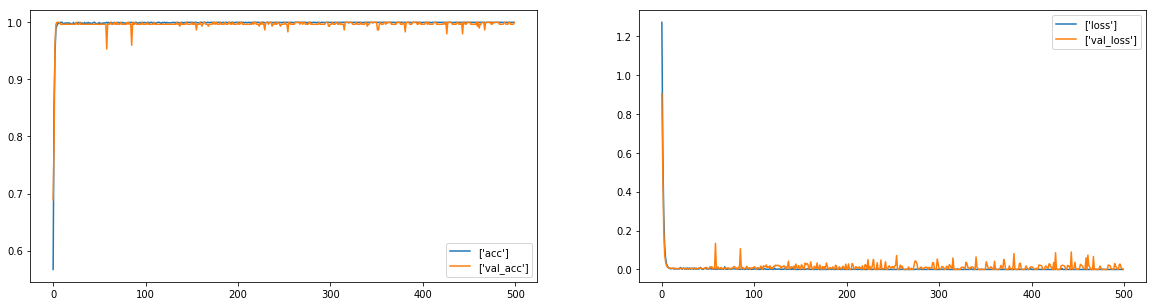

In [18]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["acc"],  label=["acc"])
plt.plot(history.history['val_acc'], label=["val_acc"])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label=["loss"]) 
plt.plot(history.history['val_loss'], label=["val_loss"])
plt.legend()

plt.show()
plt.close()

###  2.5 Evaluate with test data

In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Loss / Accuracy Evaluation")
print("--------------------------")
print("Loss:     " + str(round(test_loss,5)))
print("Accuracy: " + str(round(test_acc,5)))

374/374 [==============================] - 0s 29us/step
Loss / Accuracy Evaluation
--------------------------
Loss:     0.0
Accuracy: 1.0


In [20]:
y_tes_pred = model.predict(x_test)

In [21]:
y_tes_pred[10]

array([5.0433497e-34, 1.0000000e+00, 1.3778420e-30, 2.9094296e-11,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00], dtype=float32)

In [22]:
y_test[10]

array([0., 1., 0., 0., 0., 0., 0.], dtype=float32)

### 2.6 Save model

#### 2.6.1 h5 format

In [23]:
from keras.models import load_model
import h5py

In [24]:
# save model, delete current reference and re-load it from file
model.save('model_posture.h5')
del model
model = load_model('model_posture.h5')

In [25]:
type(model)

keras.engine.sequential.Sequential

#### 2.6.2 tensorflow.js format (JSON)

The tensorflowjs library can't be installed directly with pip / conda due to conflicting dependencies. Best is to set up a new environment explicitly for this and install tensorflowjs with the following commands:

```
pip install tensorflow==1.11.0rc2 h5py numpy keras
pip install --no-deps tensorflowjs
```

In [26]:
# ! pip install tensorflow==1.11.0rc2 h5py numpy keras
# ! pip install --no-deps tensorflowjs
# ! pip install ipykernel
# ! pip install tensorflow_hub
# import tensorflowjs as tfjs

In [27]:
# tfjs.converters.save_keras_model(model, 'model_json')

We need to adapt the two files as follows in order for them to work on Azure:
* add a file extension .pb to the file with no extension (otherwise Azure blocks it from viewing)
* adapt the automatically generated model.json to reflect the extension .pb